### Loading Dataset

In [2]:
import pandas as pd

drug_df = pd.read_csv("Data/drug.csv")
drug_df = drug_df.sample(frac=1)
drug_df.head(3)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
31,74,M,HIGH,HIGH,9.567,drugB
125,19,F,HIGH,NORMAL,25.969,DrugY
19,32,F,HIGH,NORMAL,25.974,DrugY


### Test Train Split

In [3]:
from sklearn.model_selection import train_test_split

X = drug_df.drop("Drug", axis=1).values
y = drug_df.Drug.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=125
)

### Making ML Pipeline

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

cat_col = [1,2,3]
num_col = [0,4]

transform = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(), cat_col), # converting categories into integers.
        ("num_imputer", SimpleImputer(strategy="median"), num_col), # filling missing values with the median of the column.
        ("num_scaler", StandardScaler(), num_col), # standardizing them to have mean 0 and variance 1.
    ]
)
# sequentially applies the transform and then fits a RandomForestClassifier.
pipe = Pipeline(
    steps=[
        ("preprocessing", transform),
        ("model", RandomForestClassifier(n_estimators=100, random_state=125)),
    ]
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('encoder', OrdinalEncoder(),
                                                  [1, 2, 3]),
                                                 ('num_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  [0, 4]),
                                                 ('num_scaler',
                                                  StandardScaler(), [0, 4])])),
                ('model', RandomForestClassifier(random_state=125))])

### Evaluation 

In [5]:
from sklearn.metrics import accuracy_score, f1_score

predictions = pipe.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions, average="macro")

# The average="macro" parameter indicates that the F1 score should be computed for each class and then 
# averaged without considering class imbalance. This is useful when you want to give equal weight to each class.



print("Accuracy:", str(round(accuracy, 2) * 100) + "%", "F1:", round(f1, 2))

Accuracy: 92.0% F1: 0.9


### Saving Results

In [9]:
with open("Results/metrics.txt", "w") as outfile:
    outfile.write(f"\nAccuracy = {round(accuracy,2)}, F1 Score = {round(f1,2)}.")

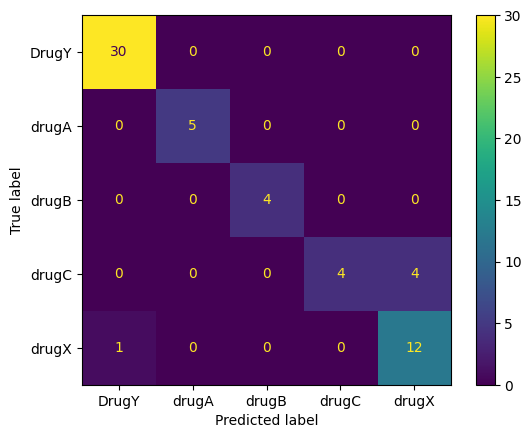

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, predictions, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot()
plt.savefig("Results/model_results.png", dpi=120)

### Saving the model

In [12]:
import skops.io as sio

sio.dump(pipe, "Model/drug_pipeline.skops")

# You can just load the entire pipeline, and it will work out of the box without processing your data or making edits to the code using the following line

# sio.load("Model/drug_pipeline.skops", trusted=True)